# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS
# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load US equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
YEAR = 12

In [6]:
START = 1995
END = 2017

In [7]:
with pd.HDFStore(r'D:\科研课题\assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [8]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10241831 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    10241831 non-null  float64
 1   high    10241831 non-null  float64
 2   low     10241831 non-null  float64
 3   close   10241831 non-null  float64
 4   volume  10241831 non-null  float64
 5   sector  10241831 non-null  object 
dtypes: float64(5), object(1)
memory usage: 508.7+ MB


In [9]:
prices

,,open,high,low,close,volume,sector
ticker,date,,,,,,
AAN,1995-01-03,1.778191,1.778191,1.778191,1.778191,0.000000e+00,Technology
AAON,1995-01-03,0.959805,1.006921,0.959805,0.997802,2.462995e+05,Capital Goods
AAPL,1995-01-03,1.235069,1.235069,1.203303,1.219186,2.596720e+07,Technology
ABAX,1995-01-03,3.296526,3.531992,3.178793,3.414259,2.560000e+04,Capital Goods
ABCB,1995-01-03,3.236605,3.236605,3.079217,3.079217,5.188000e+03,Finance
...,...,...,...,...,...,...,...
ZIXI,2017-12-29,4.420000,4.496200,4.380000,4.380000,1.856210e+05,Technology
ZNGA,2017-12-29,3.990000,4.000000,3.930000,4.000000,5.179307e+06,Technology
ZOES,2017-12-29,17.270000,17.270000,16.630000,16.720000,3.892460e+05,Consumer Services


In [10]:
len(prices.index.unique('ticker'))

2369

## Remove stocks with less than ten years of data

In [11]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [12]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    9532628 non-null  float64
 1   high    9532628 non-null  float64
 2   low     9532628 non-null  float64
 3   close   9532628 non-null  float64
 4   volume  9532628 non-null  float64
 5   sector  9532628 non-null  object 
dtypes: float64(5), object(1)
memory usage: 473.5+ MB


In [13]:
len(prices.index.unique('ticker'))

1883

## Add some Basic Factors

### Compute the Relative Strength Index

In [14]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)
# 相对强弱指标,RSI=100-[100/(1+RS)] ,RS=14天内收市价上涨数之和的平均值/14天内收市价下跌数之和的平均值

In [15]:
prices['rsi'] 

ticker  date      
AAN     1995-01-03          NaN
AAON    1995-01-03          NaN
AAPL    1995-01-03          NaN
ABAX    1995-01-03          NaN
ABCB    1995-01-03          NaN
                        ...    
ZEUS    2017-12-29    54.357447
ZION    2017-12-29    57.076071
ZIOP    2017-12-29    44.348071
ZIXI    2017-12-29    45.400332
ZUMZ    2017-12-29    52.959469
Name: rsi, Length: 9532628, dtype: float64

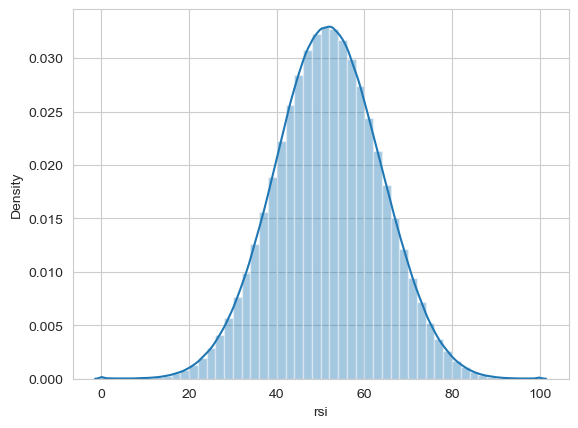

In [16]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [23]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20) #log1p(x)=log(1+x)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

布林线，BOLL指标（Bollinger Bands）。利用统计原理，求出股价的标准差及其信赖区间，以确定波动范围及未来走势。
中轨线=N日的移动平均线。
上轨线=中轨线+两倍的标准差。
下轨线=中轨线－两倍的标准差。

In [24]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [25]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     9532628 non-null  float64
 1   high     9532628 non-null  float64
 2   low      9532628 non-null  float64
 3   close    9532628 non-null  float64
 4   volume   9532628 non-null  float64
 5   sector   9532628 non-null  object 
 6   rsi      9506266 non-null  float64
 7   bb_high  9496851 non-null  float64
 8   bb_mid   9496851 non-null  float64
 9   bb_low   9496851 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1022.4+ MB


In [26]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,9.496851e+06,9.496851e+06,9.496851e+06
mean,2.954140e+00,2.881157e+00,2.808174e+00
std,1.024536e+00,1.026901e+00,1.032999e+00
min,8.933146e-03,8.933146e-03,-1.568426e+00
25%,2.303724e+00,2.226078e+00,2.146471e+00
50%,2.940911e+00,2.868116e+00,2.796484e+00
75%,3.555602e+00,3.487039e+00,3.420498e+00
max,1.376991e+01,1.358056e+01,1.346225e+01


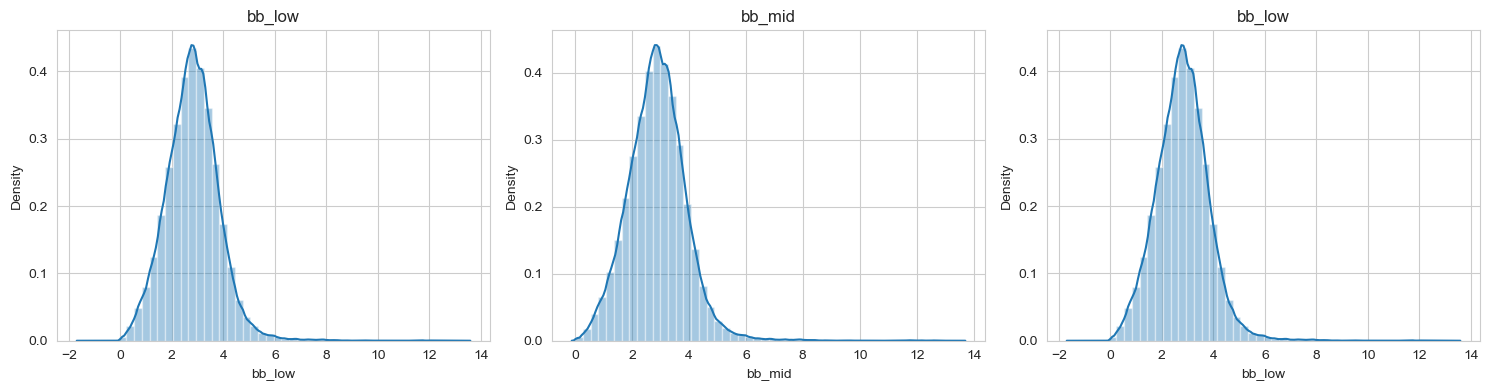

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [28]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close)) #计算布林线上涨百分比指标
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

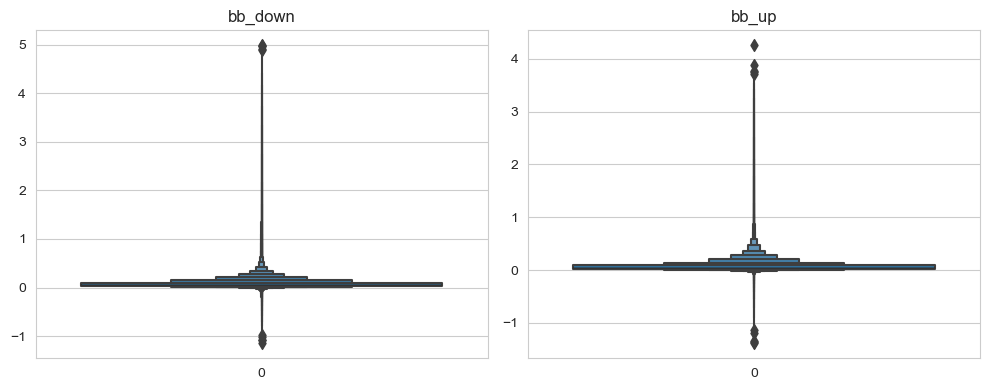

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [31]:
by_ticker = prices.groupby('ticker', group_keys=False)  #不生成新引索

In [33]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

ATR，平均真实波动幅度指标，波动率水平越高，ATR值越高，反之，波动率水平越低，ATR值也越低。

TRt = max(Ht,Ct-1)-min(Lt,Ct-1)，ATR=TRt在14日内的均值

In [34]:
prices['atr'] = by_ticker.apply(compute_atr)

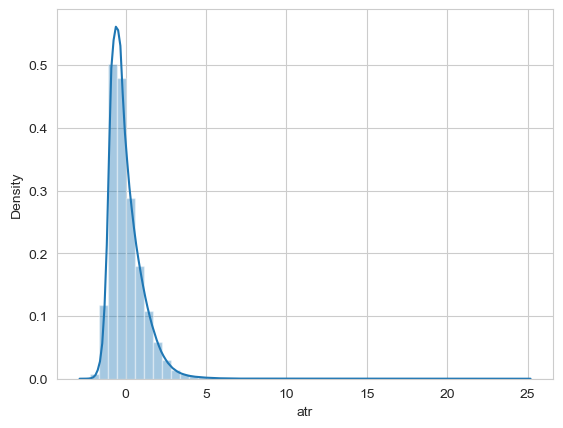

In [35]:
sns.distplot(prices.atr);

In [36]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close)) #NATR= ATR/close * 100

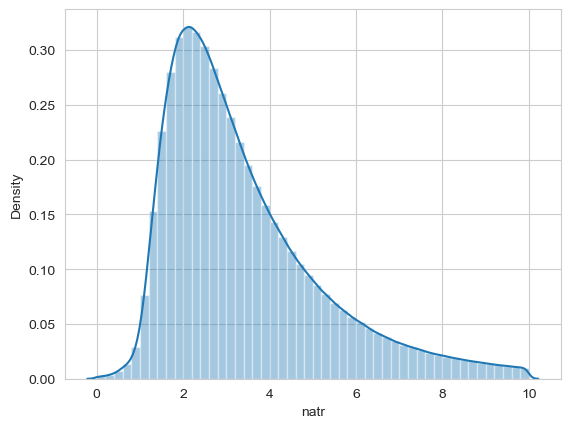

In [37]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [38]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std()) #标准化

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd)

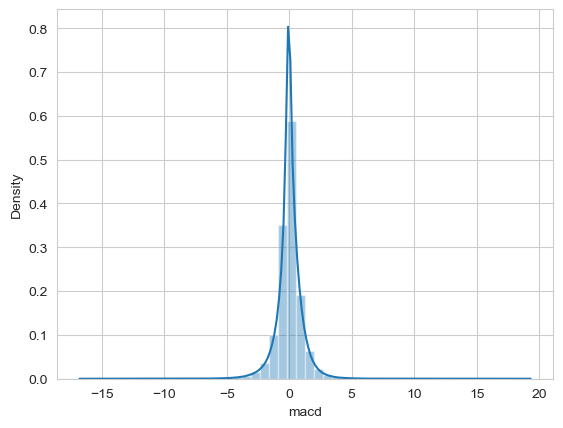

In [39]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [40]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [42]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [43]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           9532628 non-null  float64
 1   high           9532628 non-null  float64
 2   low            9532628 non-null  float64
 3   close          9532628 non-null  float64
 4   volume         9532628 non-null  float64
 5   sector         9532628 non-null  object 
 6   rsi            9506266 non-null  float64
 7   bb_high        9496851 non-null  float64
 8   bb_mid         9496851 non-null  float64
 9   bb_low         9496851 non-null  float64
 10  bb_up          9496851 non-null  float64
 11  bb_down        9496851 non-null  float64
 12  atr            9506266 non-null  float64
 13  natr           9506266 non-null  float64
 14  macd           9470489 non-null  float64
 15  dollar_volume  9532628 no

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [44]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [45]:
prices = prices.unstack('ticker')

In [46]:
prices 

open                                                          \
ticker            AAN       AAON        AAPL       ABAX       ABCB        ABM   
date                                                                            
1995-01-03   1.778191   0.959805    1.235069   3.296526   3.236605   3.436434   
1995-01-04   1.725194   1.006921    1.227128   3.414259   3.173142   3.344280   
1995-01-05   1.778191   1.101914    1.246823   3.649725   3.173142   3.344280   
1995-01-06   1.725194   1.054798    1.322426   4.238390   3.046217   3.362116   
1995-01-09   1.778191   1.082915    1.322426   4.002924   3.046217   3.422940   
...               ...        ...         ...        ...        ...        ...   
2017-12-22  40.080000  36.500000  174.680000  48.790000  49.450000  38.390000   
2017-12-26  40.150000  36.700000  170.800000  49.380000  49.150000  38.110000   
2017-12-27  40.610000  36.650000  170.100000  49.640000  48.600000  38.190000   
2017-12-28  40.520000  36.700000  171.000000  49.100000  48.500000  38.240000   
2017-12-29  40.220000  36.900000  170.520000  49.970000  48.800000  38.010000   

                                                   ... dollar_volume  \
ticker          ABMD        ABT       ACET   ACHC  ...           CIM   
date                                               ...                 
1995-01-03    2.6250   4.268868   1.706428  24.00  ...           NaN   
1995-01-04    2.5625   4.318781   1.605839  24.00  ...           NaN   
1995-01-05    2.8750   4.285944   1.632183  24.00  ...           NaN   
1995-01-06    2.7500   4.268868   1.646553  24.00  ...           NaN   
1995-01-09    2.6875   4.212490   1.646553  24.00  ...           NaN   
...              ...        ...        ...    ...  ...           ...   
2017-12-22  190.9200  57.100000  10.320000  31.93  ...     19.803890   
2017-12-26  191.3100  57.010000  10.310000  32.35  ...     25.760220   
2017-12-27  189.9600  57.090000  10.460000  32.20  ...     24.337094   
2017-12-28  190.5000  57.440000  10.290000  32.49  ...     23.577971   
2017-12-29  190.5600  57.600000  10.200000  32.68  ...     23.556548   

                                                                         \
ticker           ARR         KW       GTS      CATM       FOR       LRN   
date                                                                      
1995-01-03       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-04       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-05       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-06       NaN        NaN       NaN       NaN       NaN       NaN   
1995-01-09       NaN        NaN       NaN       NaN       NaN       NaN   
...              ...        ...       ...       ...       ...       ...   
2017-12-22  8.523758  21.486877  2.316577  5.429883  3.427137  1.811882   
2017-12-26  6.173625  25.633185  1.632204  5.174393  1.903951  2.894652   
2017-12-27  8.119724  26.535988  2.954414  3.857575  2.065709  1.405801   
2017-12-28  6.133750  16.972291  1.387455  4.228009  2.174696  1.470248   
2017-12-29  9.415783  19.849476  5.487452  4.742287  1.814428  1.443513   

                                          
ticker          TITN       TNK       ORN  
date                                      
1995-01-03       NaN       NaN       NaN  
1995-01-04       NaN       NaN       NaN  
1995-01-05       NaN       NaN       NaN  
1995-01-06       NaN       NaN       NaN  
1995-01-09       NaN       NaN       NaN  
...              ...       ...       ...  
2017-12-22  3.851540  1.606720  0.273170  
2017-12-26  3.485999  1.427873  0.233545  
2017-12-27  2.093023  1.407286  0.256812  
2017-12-28  3.247877  1.759440  0.256760  
2017-12-29  2.188131  1.963333  0.601501  

[5822 rows x 30128 columns]

In [47]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1) #resample('M')按月重采样
        .swaplevel()
        .dropna())

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 452529 entries, ('AAN', Timestamp('1995-02-28 00:00:00')) to ('ORN', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  452529 non-null  float64
 1   atr            452529 non-null  float64
 2   bb_down        452529 non-null  float64
 3   bb_high        452529 non-null  float64
 4   bb_low         452529 non-null  float64
 5   bb_mid         452529 non-null  float64
 6   bb_up          452529 non-null  float64
 7   close          452529 non-null  float64
 8   macd           452529 non-null  float64
 9   natr           452529 non-null  float64
 10  rsi            452529 non-null  float64
 11  sector         452529 non-null  object 
dtypes: float64(11), object(1)
memory usage: 43.2+ MB


In [49]:
data

,,dollar_volume,atr,bb_down,bb_high,bb_low,bb_mid,bb_up,close,macd,natr,rsi,sector
ticker,date,,,,,,,,,,,,
AAN,1995-02-28,0.076234,-0.901701,0.094985,1.102449,1.022490,1.062469,-0.015025,2.057123,-0.018766,2.986767,65.510236,Technology
AAON,1995-02-28,0.648475,-0.776136,0.011130,0.724783,0.656662,0.690722,0.056992,0.949926,-0.300224,5.914937,43.638603,Capital Goods
AAPL,1995-02-28,91.764760,-0.807437,0.018716,0.883378,0.795854,0.839616,0.068807,1.258206,-0.245760,3.714928,44.914285,Technology
ABAX,1995-02-28,0.130321,-0.795972,0.211246,1.720151,1.374962,1.547557,0.133943,3.885191,0.142463,9.825437,53.251518,Capital Goods
ABCB,1995-02-28,0.014540,-1.058002,0.054657,1.471694,1.389106,1.430400,0.027932,3.236605,-0.049239,3.337611,52.835867,Finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOR,2017-12-31,4.654602,-0.265317,0.026743,3.160547,3.108751,3.134649,0.025053,22.000000,1.101996,2.435993,60.345879,Finance
LRN,2017-12-31,2.544344,-1.248838,0.000227,2.878951,2.827086,2.853018,0.051637,15.900000,-0.007763,2.442245,40.021101,Consumer Services
TITN,2017-12-31,6.683653,-0.387205,0.028961,3.152241,3.069779,3.111010,0.053501,21.170000,1.463056,3.232475,64.981961,Consumer Services


## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [50]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume']
                         .unstack('ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel()) #五年滚动窗口，至少一年有效值

In [51]:
data['dollar_volume'] 

ticker  date      
AAN     1995-02-28         NaN
AAON    1995-02-28         NaN
AAPL    1995-02-28         NaN
ABAX    1995-02-28         NaN
ABCB    1995-02-28         NaN
                        ...   
FOR     2017-12-31    5.465228
LRN     2017-12-31    4.858840
TITN    2017-12-31    3.619377
TNK     2017-12-31    4.461620
ORN     2017-12-31    1.109383
Name: dollar_volume, Length: 452529, dtype: float64

In [56]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))
data['dollar_vol_rank'] 

ticker  date      
AAN     1995-02-28       NaN
AAON    1995-02-28       NaN
AAPL    1995-02-28       NaN
ABAX    1995-02-28       NaN
ABCB    1995-02-28       NaN
                       ...  
FOR     2017-12-31    1246.0
LRN     2017-12-31    1281.0
TITN    2017-12-31    1373.0
TNK     2017-12-31    1315.0
ORN     2017-12-31    1631.0
Name: dollar_vol_rank, Length: 452529, dtype: float64

In [57]:
data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [58]:
len(data.index.unique('ticker'))

905

## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [59]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [60]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag) #返回当前元素与lag前元素的变化百分比
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff))) #修剪极端值
                   .add(1) #每个元素+1
                   .pow(1/lag) #pow()方法返回x 的 y 次方
                   .sub(1) #每个元素-1
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 202879 entries, ('AAPL', Timestamp('1996-02-29 00:00:00')) to ('DXCM', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   202879 non-null  float64
 1   return_3m   201069 non-null  float64
 2   return_6m   198362 non-null  float64
 3   return_12m  192972 non-null  float64
dtypes: float64(4)
memory usage: 7.0+ MB


In [61]:
returns

,,return_1m,return_3m,return_6m,return_12m
ticker,date,,,,
AAPL,1996-02-29,-0.004345,NaN,NaN,NaN
ABT,1996-02-29,0.040498,NaN,NaN,NaN
ACXM,1996-02-29,-0.072727,NaN,NaN,NaN
ADBE,1996-02-29,-0.129870,NaN,NaN,NaN
ADI,1996-02-29,0.242775,NaN,NaN,NaN
...,...,...,...,...,...
ALNY,2017-12-31,-0.055671,0.026419,0.080683,NaN
EXR,2017-12-31,0.024485,0.030469,0.020926,NaN
TSS,2017-12-31,0.063609,0.064862,NaN,NaN


In [62]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,202879.000000,201069.000000,198362.000000,192972.000000
mean,0.007333,0.004950,0.004345,0.004167
std,0.085992,0.050986,0.037222,0.027246
min,-0.273767,-0.179499,-0.134177,-0.093876
25%,-0.011852,-0.003188,-0.000486,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.032949,0.023727,0.018920,0.015461
max,0.331175,0.180733,0.131169,0.099726


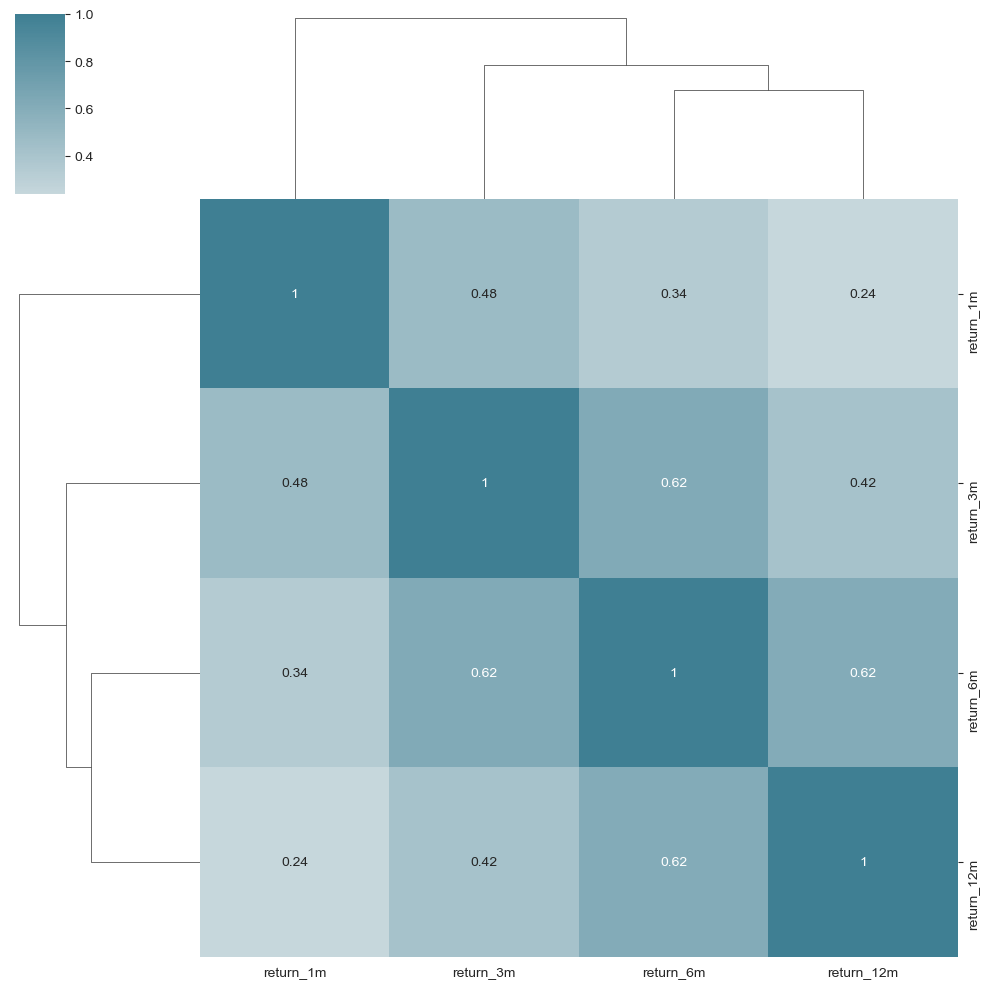

In [63]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [64]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 121589 entries, ('AAPL', Timestamp('1997-01-31 00:00:00')) to ('ULTA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   atr         121589 non-null  float64
 1   bb_down     121589 non-null  float64
 2   bb_high     121589 non-null  float64
 3   bb_low      121589 non-null  float64
 4   bb_mid      121589 non-null  float64
 5   bb_up       121589 non-null  float64
 6   macd        121589 non-null  float64
 7   natr        121589 non-null  float64
 8   rsi         121589 non-null  float64
 9   sector      121589 non-null  object 
 10  return_1m   121589 non-null  float64
 11  return_3m   121589 non-null  float64
 12  return_6m   121589 non-null  float64
 13  return_12m  121589 non-null  float64
dtypes: float64(13), object(1)
memory usage: 13.5+ MB


In [65]:
data

,,atr,bb_down,bb_high,bb_low,bb_mid,bb_up,macd,natr,rsi,sector,return_1m,return_3m,return_6m,return_12m
ticker,date,,,,,,,,,,,,,,
AAPL,1997-01-31,-0.841030,0.009233,0.462078,0.418630,0.440354,0.034216,-0.261751,3.690899,28.212160,Technology,-0.203642,-0.102638,-0.045664,-0.041444
ABT,1997-01-31,-1.061637,0.065611,2.176325,2.075932,2.126129,0.034783,0.024406,2.508402,55.935918,Health Care,0.078812,0.026453,0.037920,0.027629
ACXM,1997-01-31,0.874306,0.150220,3.109708,2.730646,2.920177,0.228842,-1.649021,5.839971,42.590344,Technology,-0.265833,-0.035286,-0.008625,0.020881
ADBE,1997-01-31,-1.210346,0.075035,1.817532,1.653720,1.735626,0.088778,-0.320211,4.213347,49.561529,Technology,0.014675,0.050151,0.037229,-0.000892
ADI,1997-01-31,-0.735707,0.113079,2.434521,2.320387,2.377454,0.001055,0.119127,3.835421,62.793388,Technology,0.141283,0.156464,0.120857,0.049619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEL,2017-12-31,1.315644,0.026071,4.586928,4.538694,4.562811,0.022163,0.608948,1.227253,53.994770,Consumer Non-Durables,0.006353,0.045935,0.032860,0.027994
CXO,2017-12-31,0.253423,0.131868,5.050531,4.886867,4.968699,0.031795,1.584802,2.143191,64.443311,Energy,0.074074,0.044781,0.035955,0.010451
VMW,2017-12-31,0.118500,0.093222,4.895616,4.745597,4.820606,0.056798,0.800535,2.056316,54.205720,Technology,0.043377,0.046998,0.061842,0.039497


In [66]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [67]:
len(data.index.unique('ticker'))

613

We are left with 613 tickers.

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [89]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1995-01-31 to 2022-10-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  334 non-null    float64
 1   SMB     334 non-null    float64
 2   HML     334 non-null    float64
 3   RMW     334 non-null    float64
 4   CMA     334 non-null    float64
dtypes: float64(5)
memory usage: 15.7 KB


In [90]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
1995-01-31,0.0180,-0.0306,0.0257,0.0017,-0.0075
1995-02-28,0.0363,-0.0054,0.0108,0.0059,-0.0033
1995-03-31,0.0219,-0.0051,-0.0215,-0.0017,0.0022
1995-04-30,0.0211,-0.0022,0.0171,0.0041,0.0090
1995-05-31,0.0290,-0.0219,0.0229,0.0039,0.0004
...,...,...,...,...,...
2022-06-30,-0.0843,0.0130,-0.0597,0.0185,-0.0470
2022-07-31,0.0957,0.0188,-0.0410,0.0068,-0.0694
2022-08-31,-0.0377,0.0151,0.0031,-0.0479,0.0130


In [91]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF'] #？
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115181 entries, ('A', Timestamp('2001-12-31 00:00:00', freq='M')) to ('ZION', Timestamp('2017-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     115181 non-null  float64
 1   SMB        115181 non-null  float64
 2   HML        115181 non-null  float64
 3   RMW        115181 non-null  float64
 4   CMA        115181 non-null  float64
 5   return_1m  115181 non-null  float64
dtypes: float64(6)
memory usage: 5.8+ MB


In [92]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-12-31  0.0160  0.0516  0.0085  0.0035 -0.0027   0.029471
       2002-01-31 -0.0144  0.0126  0.0344  0.0469  0.0283   0.078939
       2002-02-28 -0.0229 -0.0036  0.0216  0.0806  0.0511   0.049259
       2002-03-31  0.0424  0.0425  0.0106 -0.0178  0.0057   0.079911
       2002-04-30 -0.0520  0.0672  0.0388  0.0456  0.0538  -0.088446
...                   ...     ...     ...     ...     ...        ...
ZION   2017-08-31  0.0016 -0.0182 -0.0209  0.0015 -0.0237  -0.035667
       2017-09-30  0.0251  0.0477  0.0312 -0.0146  0.0168   0.055523
       2017-10-31  0.0225 -0.0193  0.0021  0.0092 -0.0324  -0.037761
       2017-11-30  0.0312 -0.0036 -0.0008  0.0319 -0.0007   0.035309
       2017-12-31  0.0106 -0.0107  0.0005  0.0074  0.0166   0.015232

[115181 rows x 6 columns]

In [93]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,115181.000000,115181.000000,115181.000000,115181.000000,115181.000000,115181.000000
mean,0.006182,0.002323,0.001869,0.003278,0.002459,0.005458
std,0.044295,0.031620,0.031330,0.029362,0.020980,0.092551
min,-0.172300,-0.153500,-0.112900,-0.187300,-0.067700,-0.387267
25%,-0.019700,-0.017000,-0.014900,-0.010700,-0.010300,-0.043905
50%,0.011700,0.001400,0.000300,0.003600,0.000100,0.002599
75%,0.034900,0.023300,0.017800,0.013900,0.014300,0.050718
max,0.113500,0.183400,0.124800,0.130900,0.090500,0.503475


In [94]:
T = 60
# betas = (factor_data
#          .groupby(level='ticker', group_keys=False)
#          .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
#                                            y=x.return_1m, 
#                                            x=x.drop('return_1m', axis=1)).beta)
#         .rename(columns={'Mkt-RF': 'beta'}))
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [95]:
betas

beta       SMB       HML       RMW       CMA
ticker date                                                        
A      2001-12-31       NaN       NaN       NaN       NaN       NaN
       2002-01-31       NaN       NaN       NaN       NaN       NaN
       2002-02-28       NaN       NaN       NaN       NaN       NaN
       2002-03-31       NaN       NaN       NaN       NaN       NaN
       2002-04-30       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
ZION   2017-08-31  0.296410  0.320123  2.070655 -0.981341 -1.780011
       2017-09-30  0.290438  0.312242  2.077740 -0.948005 -1.839265
       2017-10-31  0.279815  0.367169  1.872376 -1.022642 -1.445799
       2017-11-30  0.305790  0.426000  1.836790 -0.831808 -1.414201
       2017-12-31  0.306660  0.402459  1.821208 -0.880225 -1.289391

[115181 rows x 5 columns]

In [96]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,79014.000000,79014.000000,79014.000000,79014.000000,79014.000000,115181.000000
mean,0.066598,0.188690,0.117499,-0.018827,0.009469,0.249311
std,0.480192,0.586571,0.819292,0.878633,0.968533,1.384270
min,-1.841482,-1.995921,-4.042187,-5.201273,-5.129024,-10.004624
25%,-0.257038,-0.206762,-0.414350,-0.495432,-0.543025,-0.143136
50%,0.044411,0.147280,0.062184,0.044655,0.058279,0.000000
75%,0.370229,0.544048,0.603386,0.537252,0.603451,0.838997
max,2.739554,3.314653,4.759474,4.036887,5.085621,10.772196


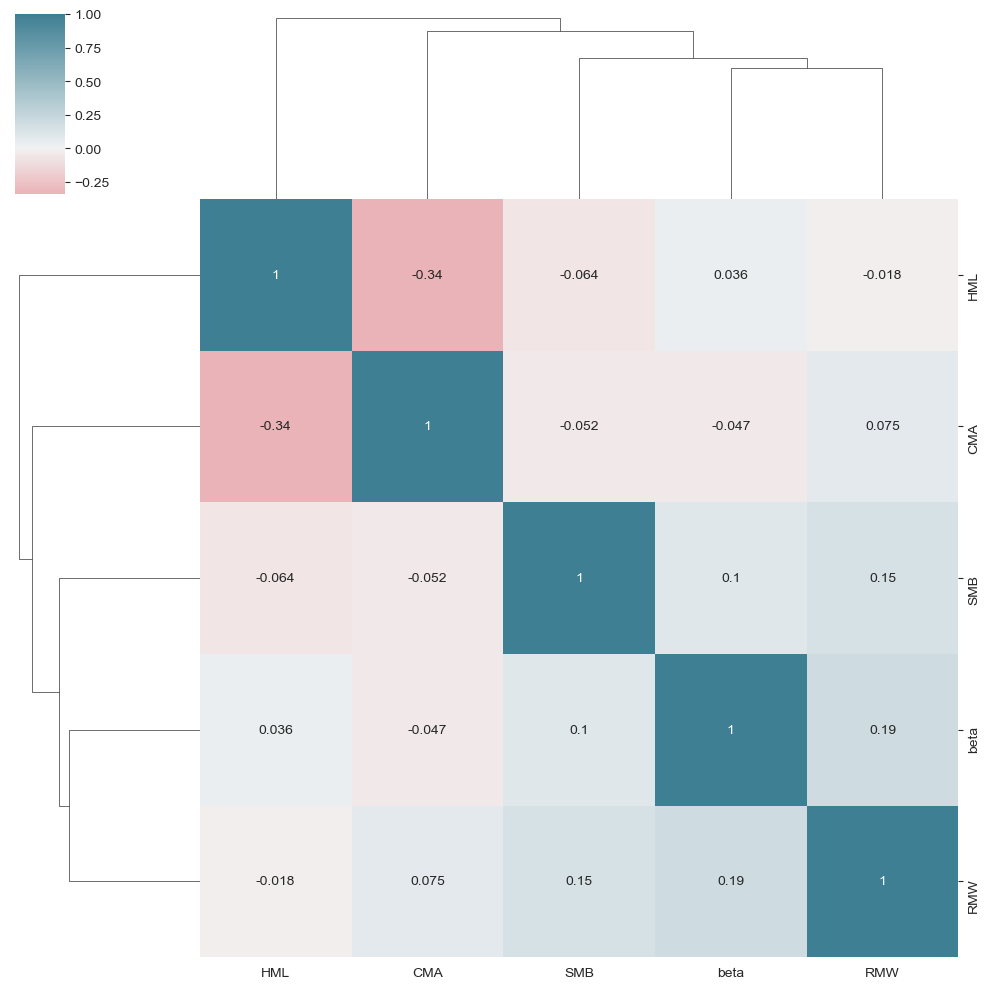

In [97]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [98]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift())
       .dropna()
       .sort_index())

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78401 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         78401 non-null  float64
 1   bb_down     78401 non-null  float64
 2   bb_high     78401 non-null  float64
 3   bb_low      78401 non-null  float64
 4   bb_mid      78401 non-null  float64
 5   bb_up       78401 non-null  float64
 6   macd        78401 non-null  float64
 7   natr        78401 non-null  float64
 8   rsi         78401 non-null  float64
 9   sector      78401 non-null  object 
 10  return_1m   78401 non-null  float64
 11  return_3m   78401 non-null  float64
 12  return_6m   78401 non-null  float64
 13  return_12m  78401 non-null  float64
 14  beta        78401 non-null  float64
 15  SMB         78401 non-null  float64
 16  HML         78401 non-null  float64
 17  RMW         78401 non-null  floa

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [100]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [104]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [105]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1) #数据向上移动1个单位

In [106]:
data = data.dropna()

In [107]:
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77788 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77788 non-null  float64
 1   bb_down        77788 non-null  float64
 2   bb_high        77788 non-null  float64
 3   bb_low         77788 non-null  float64
 4   bb_mid         77788 non-null  float64
 5   bb_up          77788 non-null  float64
 6   macd           77788 non-null  float64
 7   natr           77788 non-null  float64
 8   rsi            77788 non-null  float64
 9   sector         77788 non-null  object 
 10  return_1m      77788 non-null  float64
 11  return_3m      77788 non-null  float64
 12  return_6m      77788 non-null  float64
 13  return_12m     77788 non-null  float64
 14  beta           77788 non-null  float64
 15  SMB            77788 non-null  float64
 16  HML            7778

## Sector Breakdown

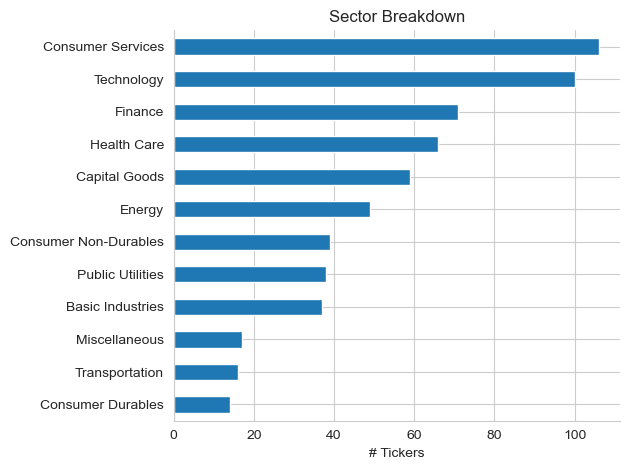

In [108]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [109]:
with pd.HDFStore('data.h5') as store:
    store.put('us/equities/monthly', data)

## Evaluate mutual information

In [121]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [122]:
mi = mutual_info_regression(X=X, y=data.target)

In [123]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr             0.111732
return_12m       0.060460
return_6m        0.054410
year             0.049377
return_3m        0.046912
momentum_3_12    0.040373
momentum_3_6     0.037777
bb_up            0.035957
momentum_12      0.035620
return_1m        0.034692
dtype: float64

In [124]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [125]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

month         0.010354
year          0.008163
return_6m     0.005127
atr           0.005069
rsi           0.004227
return_12m    0.003649
return_1m     0.002525
beta          0.002144
natr          0.001931
macd          0.001085
dtype: float64

In [126]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [127]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

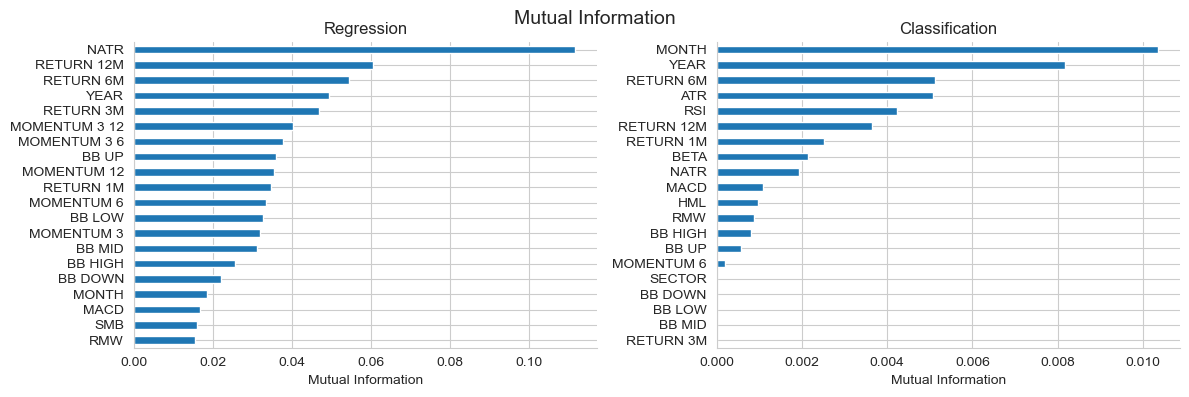

In [128]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)